In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
import orbithunter as orb
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

# Continuation
This notebook details the tools relevant to continuation, namely ```continuation``` and ```discretization_continuation```. These allow for constrained/changing the discretization in a controlled/incremental manner. First, as per usual, import some orbits.

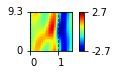

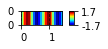

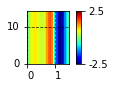

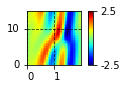

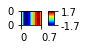

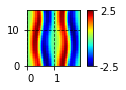

In [2]:
keys = tuple(['defect', 'double_streak', 'drifter', 'large_defect', 'streak', 'wiggle'])

fpos = orb.read_h5('./data/minimal_cover_heterogeneous.h5')

for x in fpos:
    x.plot()

Let's say that we want to numerically continue the first of these, the defect orbit, and see what its continuous family
looks like. We can do this by changing and then constraining its spatial period, `continuation` then sends this to our optimization routines.

In [3]:
defect = fpos[0]
defect.transform(to='modes')

RelativeOrbitKS({"shape": [25, 24], "basis": "modes", "parameters": [9.301, 13.091, -3.798]})

In [4]:
t0=time.time_ns()/10**9
spatial_cont_result = orb.continuation(defect.transform(to='modes'),
                                       {'x': defect.x-0.1},
                                       verbose=False,
                                       step_size=0.01,
                                       tol=1e-4,
                                       methods=('adj', 'lstsq'))
t1=time.time_ns()/10**9
print(f"Spatial continuation took {t1-t0} seconds.")

Spatial continuation took 10.88801622390747 seconds.


The original dimensions were (9.30084486170837, 13.091078488252624)


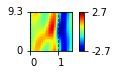

The new dimensions are (23.077853345723334, 12.991078488252626)


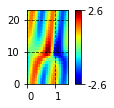

In [5]:
print(f"The original dimensions were {defect.dimensions()}")
defect.plot()
print(f"The new dimensions are {spatial_cont_result.orbit.dimensions()}")
spatial_cont_result.orbit.plot()

After we have this result in hand, you may ask: "why did we fix space and not time"? That's a good question; the temporal period changes during the continuation and so we could have chosen it as our continuation constraint. Actually, it is likely a better choice to accomplish the same goal due to the fact that it has only a first order derivative. The performance is not symmetric; smaller steps are required (anecdotally) when constraining the spatial period as opposed to time.  

In [6]:
t0=time.time_ns()/10**9
temporal_cont_result = orb.continuation(defect.transform(to='modes'),
                                        {'t': spatial_cont_result.orbit.t}, 
                                        methods='lstsq',
                                        verbose=False,
                                        step_size=5,
                                        tol=1e-4)
t1=time.time_ns()/10**9
print(f"Temporal continuation took {t1-t0} seconds.")

Temporal continuation took 4.037631988525391 seconds.


The original dimensions were (9.30084486170837, 13.091078488252624)


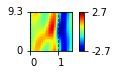

The new dimensions are (23.077853345723334, 12.99507880778735)


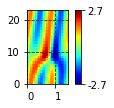

In [7]:
print(f"The original dimensions were {defect.dimensions()}")
defect.plot()
print(f"The new dimensions are {temporal_cont_result.orbit.dimensions()}")
temporal_cont_result.orbit.plot()

The first demonstration is that temporal continuation, fixing the temporal period, can be used instead of spatial continuation
which is less likely to succeed, *if* the temporal period corresponding to the spatial size is known. In other words,
if we want to get to $L=22$ from $L=18$, we can use temporal continuation if we know $T(L)|_{L=22}$.

An astute observer may notice that the solutions are not *exactly* the same. Why? The spatial shift parameters are different;
we never specified a particular phase of the Fourier modes, and so the fields can be slightly different due to interpolation
errors that arise from rotations.

# Discretization continuation

As orbits are used in tandem, it can also be useful to rediscretize and converge the result in order to make the discretized grids as similar as possible. This is accessible through ```discretization_continuation```;
provide the new discretization and then the function will try to incrementally reach a converged orbit with that size of discretization.

This function of course takes keyword arguments for the `hunt` function, the main keywords of importance 
for discretization continuation is the keyword `cycle` and keyword `axes_order`. This dictates the increment strategy to use.
If going from (16, 16)-> (32, 64), the shape goes to (16, 64) and then (32, 64) unless `cycle=True`, at which point discretization will cycle through the axes in order specified by the user via `axes_order` keyword argument.

For example: `axes_order=(1, 0)`, `initial_shape = (16, 16)`, `target_shape = (32, 64)` would rediscretize in sequence

#### `Cycle == True`
$(N_0, M_0) = (16, 16) \to (16, 18) \to (18, 18) \to\; ... \to (32, 64) = (N^*, M^*)$

#### `Cycle == False`, `axes_order==(1, 0)`
$(N_0, M_0) = (16, 16) \to\;... \to (32, 16) \to\;... \to (32, 64) = (N^*, M^*)$ 


If, of course, the increment is specified to be 2 in each dimension.

In [8]:
rpo = orb.read_h5('./data/RelativeOrbitKS.h5')[177]
t0 = time.time_ns()/10**9
time_disc_continuation = orb.discretization_continuation(rpo, (36, rpo.m),
                                          verbose=False,
                                          cycle=True,
                                          methods=('lsmr','lstsq'),
                                          tol=[1e-3, 1e-6],
                                          maxiter=[1000,1000],
                                         scipy_kwargs={"atol": 1e-4, "btol": 1e-4})
t1 = time.time_ns()/10**9
print(f"Discretization continuation from {rpo.discretization} to"
      f" {time_disc_continuation.orbit.discretization} took {t1-t0} seconds")
print(f"The final result has cost {time_disc_continuation.orbit.cost()}")

Discretization continuation from (32, 32) to (34, 32) took 144.4783320426941 seconds
The final result has cost 0.0007433871510761469


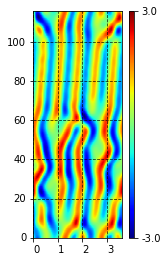

In [9]:
time_disc_continuation.orbit.plot(padding=True)

In [10]:
rpo = orb.read_h5('./data/RelativeOrbitKS.h5')[177]
t0 = time.time_ns()/10**9
space_disc_continuation = orb.discretization_continuation(rpo, (rpo.n, 48),
                                          verbose=False,
                                          cycle=True,
                                          methods=('lsmr','lstsq'),
                                          tol=[1e-3, 1e-6],
                                          maxiter=[1000,1000],
                                         scipy_kwargs={"atol": 1e-4, "btol": 1e-4})
t1 = time.time_ns()/10**9
print(f"Discretization continuation from {rpo.discretization} to"
      f" {space_disc_continuation.orbit.discretization} took {t1-t0} seconds")
print(f"The final result has cost {space_disc_continuation.orbit.cost()}")

Discretization continuation from (32, 32) to (32, 48) took 4.048020839691162 seconds
The final result has cost 2.026887631418593e-07


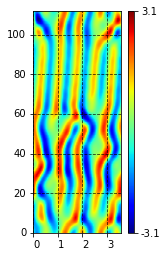

In [11]:
space_disc_continuation.orbit.plot(padding=True)

As can see, while th spatial discretization size was able to be increased to 48 without much trouble or effort,
the temporal discretization continuation stalled. It's hard to decide as to why this is the result, I believe that
it is likely due to an amount of aliasing with respect to the temporal modes. There are theoretical arguments for allowing
the calculations to be aliased. Typically the argument against this is that it affects the numerical stability of integration routines. There is no integration here, so there is no propagation of error that accumulates/grows over time. The other argument is that it affects the physical observables associated with the different modes. This is a more subtle point, the main hope being that either discretization continuation or allowing for the errors does not contaminate the future results with
respect to physical observables. The main reason for the allowance of aliasing is simply to reduce the number of computational
degrees of freedom.


# Generating continuous families

The fact that orbits come defined on "rubbery tiles", that is, continuous families parameterized by 
This is also automated through the ```span_family``` function. This function requires bounds, step_sizes, and the orbit to serve as the "root" of the branches.

The idea is that there is a multi-dimensional manifold defining a continuous family of periodic orbits, parameterized
by the tile defining and other parameters. 

In [10]:
root_orbits = orb.read_h5('./data/roots.h5')
root_orbits.pop(3)
root_orbits

[RelativeOrbitKS({"shape": [26, 26], "basis": "field", "parameters": [17.151, 13.02, -3.313]}),
 RelativeOrbitKS({"shape": [26, 26], "basis": "field", "parameters": [8.43, 13.2, -3.943]}),
 RelativeOrbitKS({"shape": [34, 34], "basis": "field", "parameters": [17.371, 17.568, -5.688]}),
 EquilibriumOrbitKS({"shape": [12, 12], "basis": "field", "parameters": [0.0, 7.396, 0.0]}),
 AntisymmetricOrbitKS({"shape": [34, 34], "basis": "field", "parameters": [17.151, 17.591, 0.0]})]

This next bit is commented out because it takes a long time to finish, and the results have already been saved.

In [1]:
# keys = tuple(['defect', 'drifter', 'large_defect', 'wiggle'])

# covering_families = []
# if not os.path.isfile('./data/covering_heterogeneous.h5'):
#     for name, window in zip(keys, root_orbits):
#         if name not in ['streak', 'double_streak']:
#             print(name)
#             bounds = {'t': (0.9*window.t, 1.1*window.t)}
#             step_sizes = {'t': 0.001}
#             window = orb.hunt(window.transform(to='modes'), methods='lstsq', tol=1e-10).orbit
#             print(window.cost())
#             family_cont = orb.span_family(window, bounds=bounds, step_sizes=step_sizes, tol=[1e-2, 1e-6],
#                                       maxiter=[10000, 200],# sampling_rate=10,
#                                       verbose=False, methods=('adj', 'lsmr'), ftol=0, preconditioning=[True, False],
#                                       filename='./data/covering_heterogeneous.h5', groupname=name, h5mode='a')
#             covering_families.append(family_cont)
#             print('#')
#         else:
#             continue
#             print(name)
#             bounds = {'x': (window.x, 2*window.x)}
#             step_sizes = {'x': 0.1}
#             window = orb.hunt(window.transform(to='modes').resize(1, 12), methods='lstsq', tol=1e-10).orbit
#             family_cont = span_family(window, bounds=bounds, step_sizes=step_sizes,
#                                       tol=[1e-4, 1e-6], maxiter=[25000, 200],
#                                       verbose=False, methods=('adj', 'lstsq'), ftol=0,
#                                       preconditioning=[True, False], sampling_rate=10,
#                                       filename='./data/covering_heterogeneous.h5',
#                                       groupname=name, h5mode='a')
#             covering_families.append(family_cont)